Group Members: Rosamelia Carioni, Elena Perego, Mischa Rauch.
Student IDs:

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from numpy import sqrt
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import reciprocal
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.metrics import r2_score

2023-03-23 19:12:06.887068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Import data TODO: House density

In [2]:
crime_density = pd.read_csv('clean_data/crime.csv')
median_gross_earning = pd.read_csv('clean_data/median_gross_annual_earning.csv')
personal_well_being = pd.read_csv('clean_data/personal_well_being.csv')
population = pd.read_csv('clean_data/population_annual.csv')
waste = pd.read_csv('clean_data/waste.csv')
gas_energy_consumption = pd.read_csv('clean_data/energy_gas_consumption_annual.csv')
electricity_energy_consumption = pd.read_csv('clean_data/energy_electricity_consumption_annual.csv')
housing_density = pd.read_csv('clean_data/housing_density.csv')
# Both median and mean were stracted for experimentation purposes, however, for the final model the median will be considered.
median_house_price = pd.read_csv('clean_data/median_house_price.csv')

# 2. Clean and Structure the data

This step was done in the files 'reding_data_x.ipynb' where x={1,2,3}. In these files, the data was read, as extracted from London Data Store, and structured so that all of them had the same structure and features. The dataframes will be merged into one dataframe in step 5, after the outlier removal is done and the correlation with the house price is checked.

In [3]:
#df = crime_density.groupby(['Code', 'Year'])['Value'].sum().reset_index().pivot(index='Code', columns='Year', values='Value')

merge1 = pd.merge(crime_density,median_gross_earning, on = ['Area','Code','Year'], how = 'outer')
merge2 = pd.merge(merge1, personal_well_being, on = ['Area','Code','Year'], how = 'outer')
merge3 = pd.merge(merge2, population, on = ['Area','Code','Year'], how = 'outer')
merge4 = pd.merge(merge3, waste, on = ['Area','Code','Year'], how = 'outer')
merge5 = pd.merge(merge4, median_house_price, on = ['Area','Code','Year'], how = 'outer')
data = pd.merge(merge5, housing_density, on = ['Area','Code','Year'], how = 'outer')
#merge6 = pd.merge(merge5, gas_energy_consumption, on = ['Area','Code','Year'])
#data = pd.merge(merge6, electricity_energy_consumption, on = ['Area','Code','Year'])

# Fix the housing density
data['Housing_density'] = data['Housing_density'] / data['Population_estimates']
data

Code                  Area  Year  Number_of_crimes  \
0    E09000002  Barking and Dagenham  2011            1635.0   
1    E09000003                Barnet  2011            2243.0   
2    E09000004                Bexley  2011             982.0   
3    E09000005                 Brent  2011            2601.0   
4    E09000006               Bromley  2011            1797.0   
..         ...                   ...   ...               ...   
226  E09000001        City of London  2013               NaN   
227  E09000001        City of London  2014               NaN   
228  E09000001        City of London  2015               NaN   
229  E09000001        City of London  2016               NaN   
230  E09000001        City of London  2017               NaN   

     Median_annual_earning  Mean_life_satisfaction  Population_estimates  \
0                    28201                    7.05                187029   
1                    30237                    7.43                357538   
2                    28638                    7.42                232774   
3                    26772                    7.11                312245   
4                    28163                    7.50                310554   
..                     ...                     ...                   ...   
226                  54202                     NaN                  7648   
227                  54710                     NaN                  8072   
228                  54034                     NaN                  8760   
229                  55487                     NaN                  9401   
230                  56295                     NaN                  7654   

     Waste_recycling_rates  Median_house_price  Housing_density  
0                  30.0000            170000.0         0.380043  
1                  33.6000            325000.0         0.389738  
2                  53.5000            215000.0         0.408280  
3                  36.8000            300000.0         0.358959  
4                  49.9000            275000.0         0.434823  
..                     ...                 ...              ...  
226                38.8000            615000.0         0.727772  
227                34.4000            769100.0         0.743682  
228                30.8000            799999.5         0.711073  
229                28.5000            831400.0         0.670780  
230                29.2366            835000.0         0.824797  

[231 rows x 10 columns]

In [4]:
corr = data.corr()
corr

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_64291/2601176157.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


Year  Number_of_crimes  Median_annual_earning  \
Year                    1.000000         -0.027121               0.096324   
Number_of_crimes       -0.027121          1.000000               0.499517   
Median_annual_earning   0.096324          0.499517               1.000000   
Mean_life_satisfaction  0.553585         -0.257947              -0.026321   
Population_estimates    0.092682          0.385204              -0.449936   
Waste_recycling_rates  -0.050152         -0.485251              -0.284225   
Median_house_price      0.399308          0.275613               0.415401   
Housing_density        -0.052241          0.268462               0.677733   

                        Mean_life_satisfaction  Population_estimates  \
Year                                  0.553585              0.092682   
Number_of_crimes                     -0.257947              0.385204   
Median_annual_earning                -0.026321             -0.449936   
Mean_life_satisfaction                1.000000             -0.057358   
Population_estimates                 -0.057358              1.000000   
Waste_recycling_rates                 0.164894              0.011550   
Median_house_price                    0.317143             -0.392131   
Housing_density                      -0.010687             -0.697874   

                        Waste_recycling_rates  Median_house_price  \
Year                                -0.050152            0.399308   
Number_of_crimes                    -0.485251            0.275613   
Median_annual_earning               -0.284225            0.415401   
Mean_life_satisfaction               0.164894            0.317143   
Population_estimates                 0.011550           -0.392131   
Waste_recycling_rates                1.000000           -0.305115   
Median_house_price                  -0.305115            1.000000   
Housing_density                     -0.143548            0.615495   

                        Housing_density  
Year                          -0.052241  
Number_of_crimes               0.268462  
Median_annual_earning          0.677733  
Mean_life_satisfaction        -0.010687  
Population_estimates          -0.697874  
Waste_recycling_rates         -0.143548  
Median_house_price             0.615495  
Housing_density                1.000000

<AxesSubplot: >

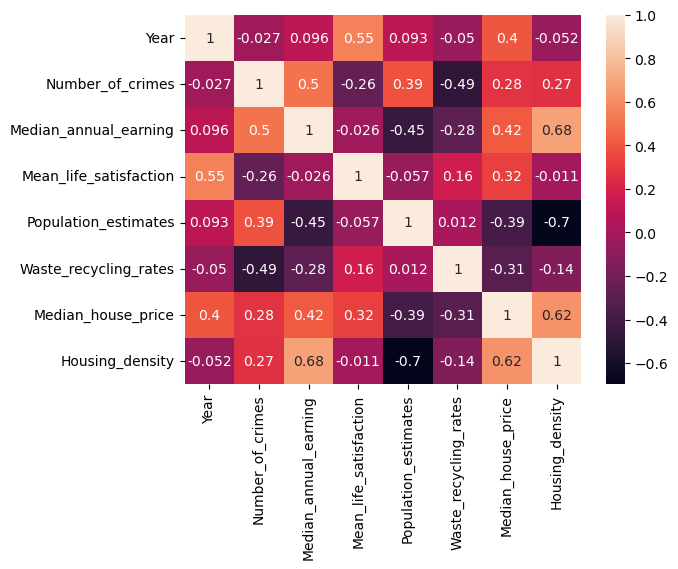

In [5]:
sns.heatmap(corr, annot=True)

# 3. EDA: Outlier Removal (each does its own --> same as clinic but also make nicer)
# TODO: write that we do not remove outliers

## Helper functions

In [6]:
red = 'YlOrRd'
blue = 'BuPu'
green = 'YlGn'
def create_map(feature_name, color):
    # create a map centered on London
    london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

    # add choropleth layer to the map
    folium.Choropleth(
        geo_data='clean_data/london_boroughs.json',
        name='choropleth',
        data=data,
        columns=['Area', feature_name],
        key_on='feature.properties.name',
        fill_color= color,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=feature_name
    ).add_to(london_map)
    # add layer control to the map
    folium.LayerControl().add_to(london_map)
    # display the map
    return london_map

# Group data by year and calculate the mean of 'Mean_life_satisfaction'
def time_series_over_year(feature_name):
    mean_satisfaction = data.groupby('Year')[feature_name].mean()
    # Create a line plot of mean life satisfaction by year
    plt.plot(mean_satisfaction.index, mean_satisfaction.values)

    # Add labels and title to the plot
    plt.xlabel('Year')
    plt.ylabel(feature_name)

    # Show the plot
    plt.show()


def standardize_columns(data):
    # (value - mean) / std
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized
      to have 0-mean and unit variance
    '''
    mean_per_column = data.mean(axis=0, numeric_only = True) # This is not really needed, you can just do data.mean()
    std_per_column = data.std(axis=0, numeric_only = True)
    return (data - mean_per_column)/std_per_column


def joint_plot_satisfaction(feature_name, data):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x= feature_name,
        y='Mean_life_satisfaction',
        data=data.sort_values(feature_name),
        ax=axs[0]
    )

    sns.countplot(
        x= feature_name,
        data=data.sort_values(feature_name),
        ax=axs[1]
    )

    # Draw median price
    axs[0].axhline(
        y=data['Mean_life_satisfaction'].median(),
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)


def plot_linear_relationship_and_spread(x_name, data, y_name):
    sns.jointplot(
        x=x_name,
        y=y_name,
        data=data,
        #    stat_func=None,
        kind="reg",
        ratio=4,
        space=0,
        scatter_kws={
            's': 3,
            'alpha': 0.25
        },
        line_kws={
            'color': 'black'
        }
    )

# 4. EDA: Visualizations 

## Housing Density

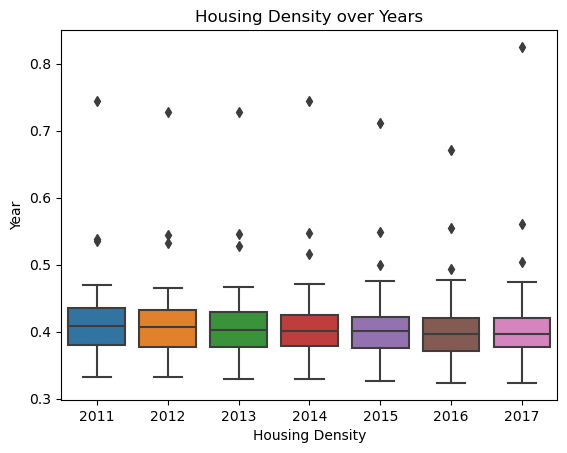

In [7]:
sns.boxplot(x = "Year",y="Housing_density",data = data)

# set the axis labels
plt.xlabel('Housing Density')
plt.ylabel('Year')

# set the title
plt.title('Housing Density over Years')

# display the plot
plt.show()

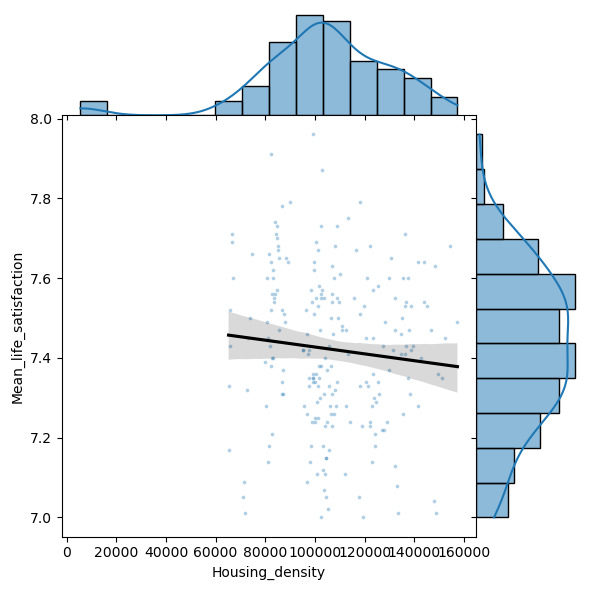

In [8]:
temp = data.copy()
temp['Housing_density'] = temp['Housing_density'] * temp['Population_estimates']
plot_linear_relationship_and_spread('Housing_density',temp, 'Mean_life_satisfaction')


## Population

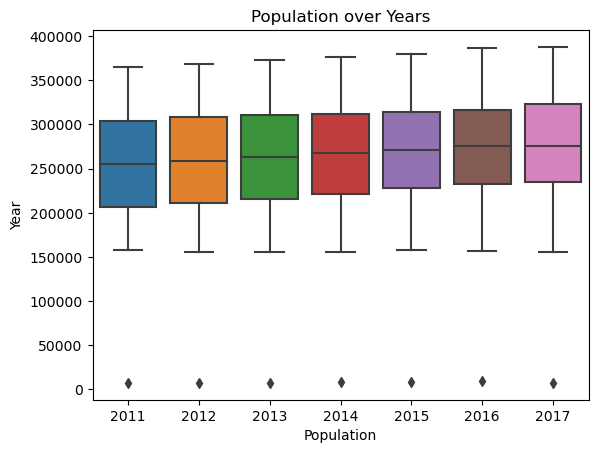

In [9]:
import seaborn as sns
sns.boxplot(x = "Year",y="Population_estimates",data = data)

# set the axis labels
plt.xlabel('Population')
plt.ylabel('Year')

# set the title
plt.title('Population over Years')


# display the plot
plt.show()

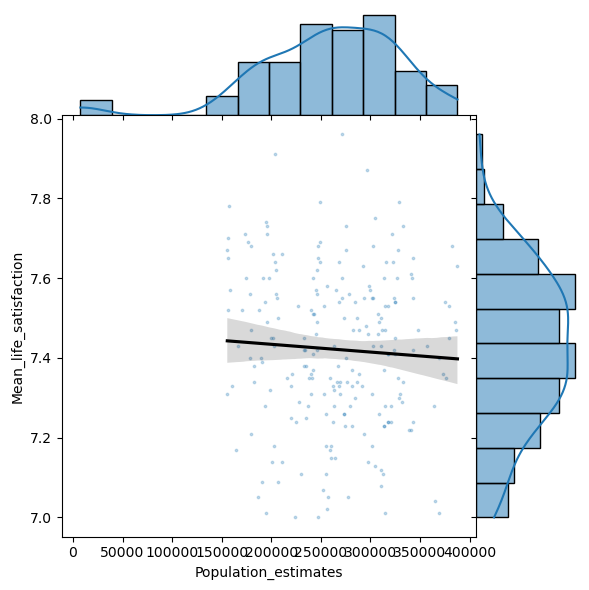

In [10]:
plot_linear_relationship_and_spread('Population_estimates',data,'Mean_life_satisfaction')

This should show correlations with happiness per feature. Meli: do happiness with year and neighbourhood.

## Personal Well-Being over the Years

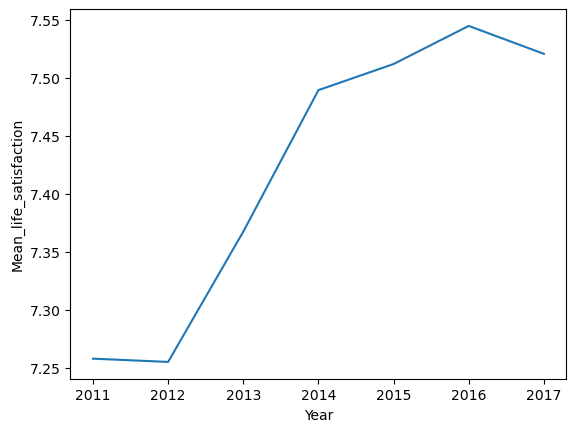

In [11]:
time_series_over_year('Mean_life_satisfaction')

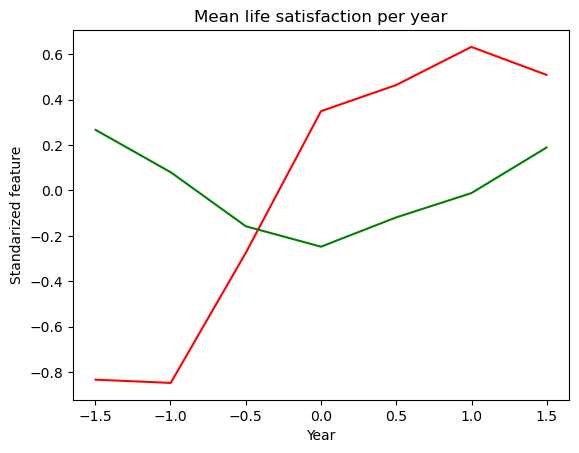

In [12]:
temp = data
temp = standardize_columns(temp)

# Group data by year and calculate the mean of 'Mean_life_satisfaction'
mean_satisfaction = temp.groupby('Year')['Mean_life_satisfaction'].mean()
mean_crimes = temp.groupby('Year')['Number_of_crimes'].mean()

year = range(2011,2017)
# Create a line plot of mean life satisfaction by year
plt.plot(mean_satisfaction.index, mean_satisfaction.values, color = 'r')
plt.plot(mean_crimes.index, mean_crimes.values, color = 'g')

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Standarized feature')
plt.title('Mean life satisfaction per year')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Mean life satisfaction per year')

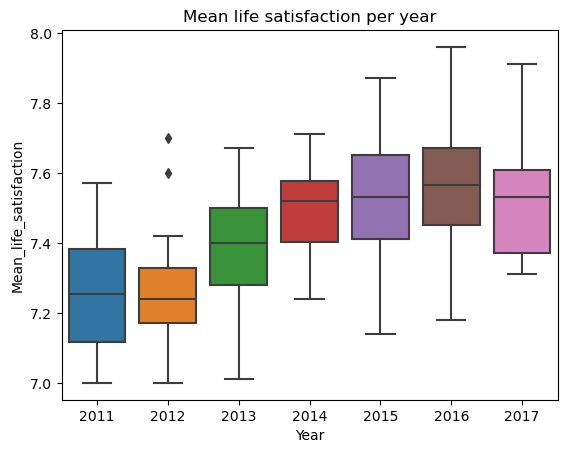

In [13]:
sns.boxplot(x="Year", y="Mean_life_satisfaction", data=data)
plt.title('Mean life satisfaction per year')

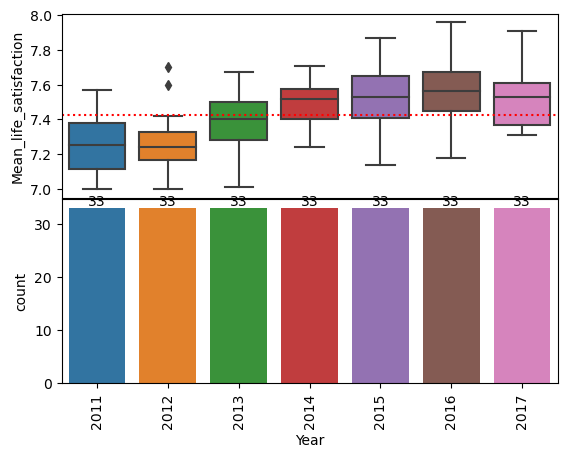

In [14]:
joint_plot_satisfaction('Year',data)

## Neighbourhoods and Personal Well-Being

In [15]:
map_satisfaction = create_map('Mean_life_satisfaction', red)
map_satisfaction

## Average House Price and Personal Well-Being


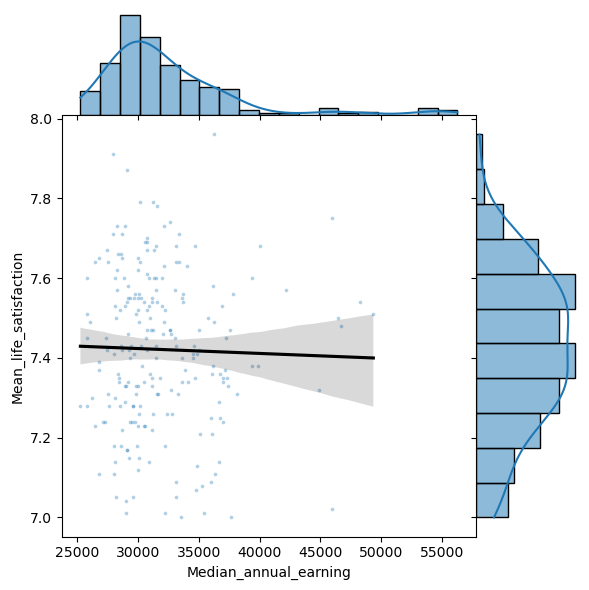

In [16]:
#plot_linear_relationship_and_spread('Median_house_price', data)
# Mischa comment I think we don't need this anymore do we?
plot_linear_relationship_and_spread('Median_annual_earning', data, 'Mean_life_satisfaction')

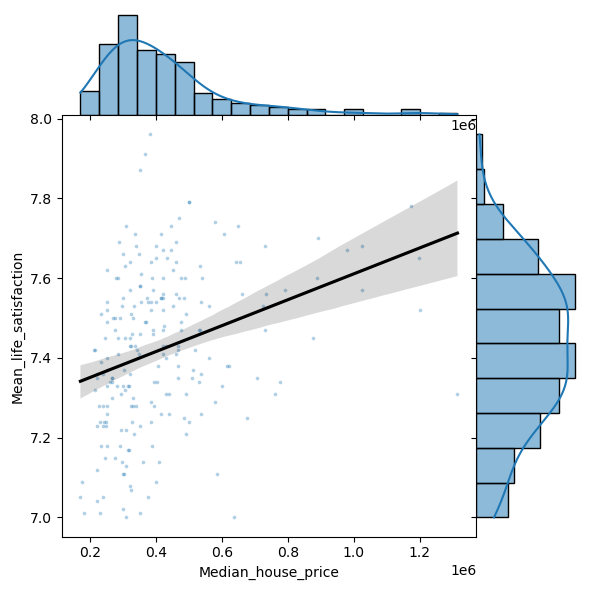

In [17]:
plot_linear_relationship_and_spread('Median_house_price', data, 'Mean_life_satisfaction')

In [18]:
map = create_map('Median_annual_earning', red)
map

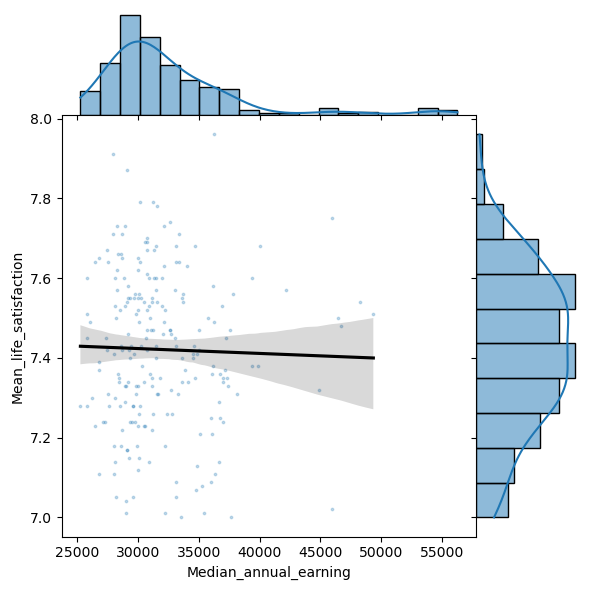

In [19]:
#plot_linear_relationship_and_spread('Median_house_price', merge5)
plot_linear_relationship_and_spread('Median_annual_earning', data, 'Mean_life_satisfaction')


## Average Income and Personal Well-Being


### Make plot --> RQ 1 --> "How does location of neighborhoods affect personal well-being in London?"  (ELENA)

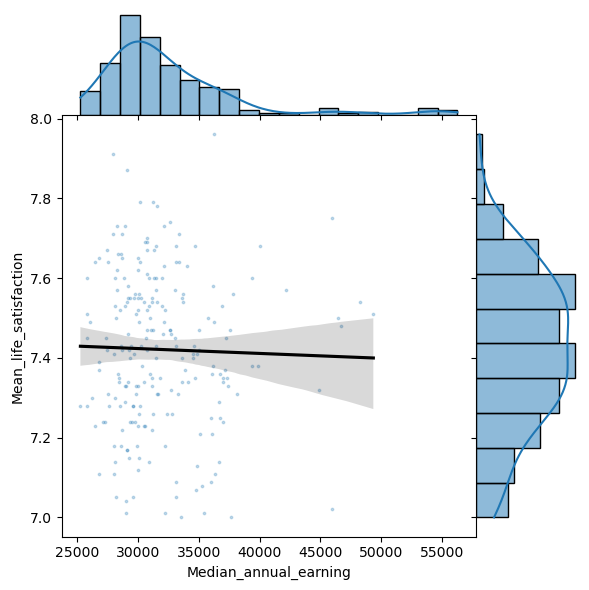

In [20]:
plot_linear_relationship_and_spread('Median_annual_earning', data, 'Mean_life_satisfaction')

## Crime rates and Personal Well-Being

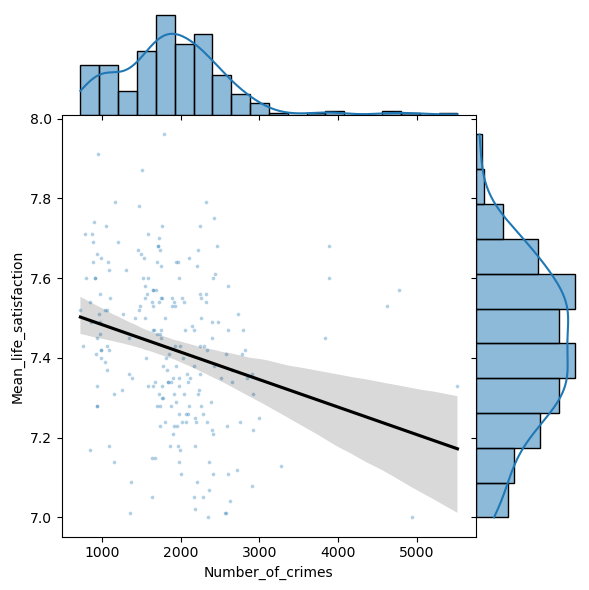

In [21]:
plot_linear_relationship_and_spread('Number_of_crimes', data, 'Mean_life_satisfaction')

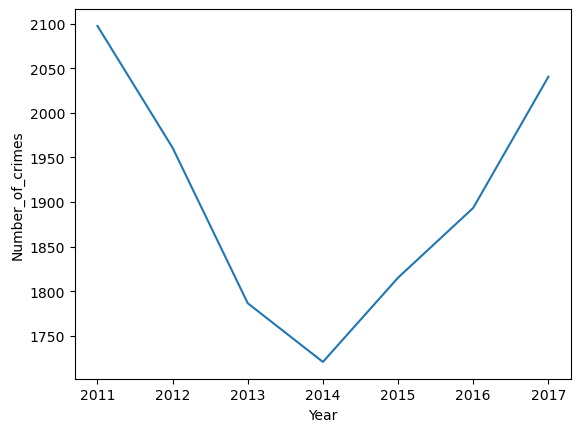

In [22]:
time_series_over_year('Number_of_crimes')

In [23]:
map_crime = create_map('Number_of_crimes', blue)
map_crime

## Waste

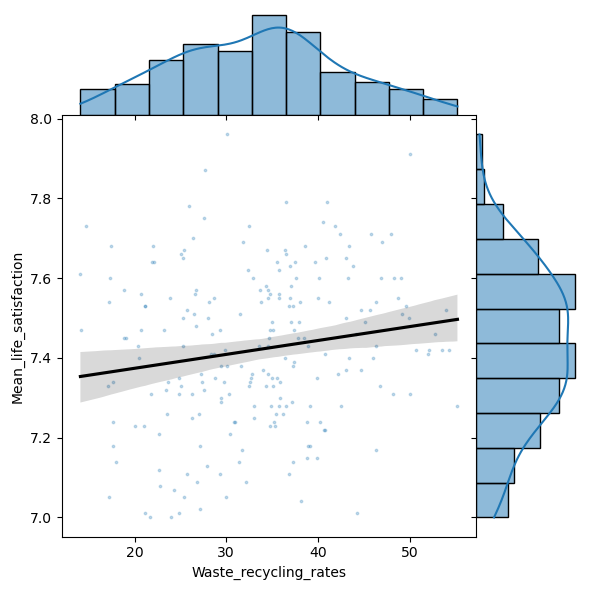

In [24]:
plot_linear_relationship_and_spread('Waste_recycling_rates', data, 'Mean_life_satisfaction')

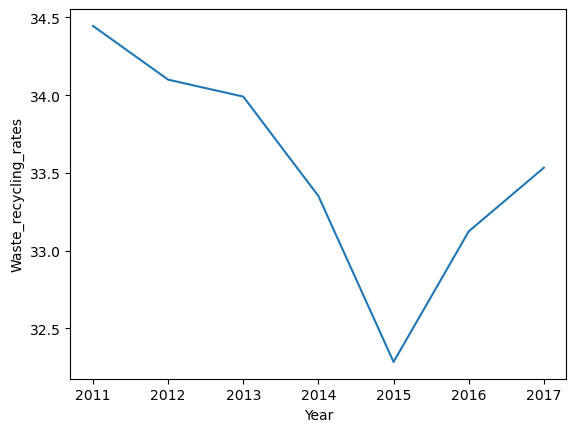

In [25]:
time_series_over_year('Waste_recycling_rates')

In [26]:
map_waste = create_map('Waste_recycling_rates', green)
map_waste

### Compare all variables with nice plots to house price --> RQ 2  (Meli: hers + crime, Mischa: his + house density, Ele: waste)

# 5. Models for Personal-Wellbeing Prediction

In [27]:
# Ignore DeprecationWarning - we get it normalization = true is deprecated
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 5.0 Create training set (ALL: based on results from before, create a df, verifying the correlation of variables) S

In [37]:
def ohe_code(data):
    """
    One-hot-encodes a feature.  New columns are of the form zone_AREA
    """
    cats = [
        'City of London', 
        'Barking and Dagenham', 
        'Barnet', 
        'Bexley', 
        'Brent', 
        'Bromley',
        'Camden', 
        'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'
    ]

    cat_type = CategoricalDtype(categories=cats)

    data['Area'] = data['Area'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='area',
                          columns=['Area'],
                          drop_first=True)

    return data

In [38]:
train_set, test_set = train_test_split(data.dropna(), test_size=0.20, random_state=123)
X_train = train_set.drop(['Mean_life_satisfaction','Code'],axis=1)
y_train = train_set['Mean_life_satisfaction']
X_test = test_set.drop(['Mean_life_satisfaction','Code'],axis=1)
y_test = test_set['Mean_life_satisfaction']


# Fit Data
num_attribs = list(X_train.select_dtypes('number'))
cat_attribs = list(X_train.select_dtypes('object'))

pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attribs),
    #('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])

X_train_prepared = ohe_code(X_train)
X_test_prepared = ohe_code(X_test)

X_train_prepared = pipeline.fit_transform(X_train_prepared)
X_test_prepared = pipeline.transform(X_test_prepared)


In [39]:
X_train_prepared

array([[-1.47906383,  0.06574647,  0.97873604, ..., -0.35743694,
         0.21182983,  0.93076157],
       [ 1.12164762, -1.42658923, -0.24499464, ...,  1.50453563,
         0.18726991, -0.61955986],
       [ 1.12164762, -0.20919477,  0.72038285, ..., -1.11765059,
         1.51350557,  1.46248285],
       ...,
       [-0.43877925, -1.35431087, -0.7461049 , ...,  2.40797794,
        -0.96704631, -0.07496587],
       [ 0.08136304, -0.34383094, -0.16452768, ..., -1.39309032,
         0.54216075,  0.7131294 ],
       [ 0.08136304, -1.30895973, -1.3055311 , ...,  1.29520144,
        -0.25480864, -1.05940647]])

## 5.1 Linear Regression (elena)

In [40]:
lin_reg = LinearRegression(normalize=True) # l2 normalization
lin_reg.fit(X_train_prepared, y_train)
lin_reg.intercept_, lin_reg.coef_
print("Score: ",lin_reg.score(X_train_prepared,y_train))

predict = lin_reg.predict(X_test_prepared)

# Print the coefficients with their feature names
print("Coefficients:")
feature_names = data.columns.drop(['Mean_life_satisfaction','Area'])
for feature_name, coef in zip(feature_names, lin_reg.coef_):
    print(feature_name, ':', coef)

print("COEFFICENT " ,lin_reg.coef_)



print('R2 Score ', r2_score(y_test, predict))
print("Mean Square Error: ", mean_squared_error(y_test, predict))
print("Root Mean Squared Error ", sqrt(mean_squared_error(y_test,predict)))
print("Mean Absolute Error ", mean_absolute_error(y_test,predict))
print("Mean Absolute Percentage Error ", mean_absolute_percentage_error(y_test,predict))

Score:  0.4515497074148006
Coefficients:
Code : 0.07409893846204701
Year : -0.0757410039644844
Number_of_crimes : 0.019755301892402412
Median_annual_earning : 0.021867114434852567
Population_estimates : 0.021188273635890736
Waste_recycling_rates : 0.08996550496653336
Median_house_price : -0.02767076119825337
COEFFICENT  [ 0.07409894 -0.075741    0.0197553   0.02186711  0.02118827  0.0899655
 -0.02767076]
R2 Score  0.3041588323813289
Mean Square Error:  0.027512494529311565
Root Mean Squared Error  0.16586890766298415
Mean Absolute Error  0.1310828282498774
Mean Absolute Percentage Error  0.017647300895163347


/opt/anaconda3/envs/DataAnalysis/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


## 5.2 Polynomial Regression (Mischa)

In [41]:
poly_lin_mod = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression(normalize=True))
    ])

start = datetime.now()


poly_lin_mod.fit(X_train_prepared, y_train)
score = cross_validate(poly_lin_mod, X_train_prepared, y_train, cv=3)

predict = poly_lin_mod.predict(X_test_prepared)
end = datetime.now()
print("Score: ",poly_lin_mod.score(X_train_prepared,y_train))
print('R2 Score ', r2_score(y_test, predict))
print("Mean Square Error: ", mean_squared_error(y_test, predict))
print("Root Mean Squared Error ", sqrt(mean_squared_error(y_test,predict)))
print("Mean Absolute Error ", mean_absolute_error(y_test,predict))
print("Mean Absolute Percentage Error ", mean_absolute_percentage_error(y_test,predict))
print("---------------------")
print("Elapsed", (end - start).total_seconds(), "seconds")

Score:  0.6571544652709105
R2 Score  0.33379764614095486
Mean Square Error:  0.026340621206254796
Root Mean Squared Error  0.1622979396241825
Mean Absolute Error  0.13081633411543628
Mean Absolute Percentage Error  0.017533607090253724
---------------------
Elapsed 0.012891 seconds


/opt/anaconda3/envs/DataAnalysis/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/envs/DataAnalysis/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.

## 5.3 Random Forest (Meli)

In [43]:
rf_reg = RandomForestRegressor(n_estimators=50, max_features=5)
est = rf_reg.fit(X_train_prepared, y_train)

price_predictions = est.predict(X_test_prepared)
randomforest_rmse = np.sqrt(mean_squared_error(y_test, price_predictions))
print('R2 Score ', r2_score(y_test, price_predictions))
print('mean squared error: ', mean_squared_error(y_test, price_predictions))
print('Root mean squared error: ', randomforest_rmse)
print('mean absolute error: ', mean_absolute_error(y_test, price_predictions))
print('mean absolute percentage error: ', mean_absolute_percentage_error(y_test, price_predictions))

R2 Score  0.5696256460343676
mean squared error:  0.017016343111111075
Root mean squared error:  0.13044670601863076
mean absolute error:  0.10957333333333305
mean absolute percentage error:  0.014739814106860712


## 5.4 Neural Network (Mischa)

In [ ]:
# create a validation dataset to account for overfitting
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=123)

X_valid_prepared = pipeline.transform(X_valid)

#X_train_prepared = X_train1.to_numpy() 
#X_valid_prepared = X_valid.to_numpy()
#X_test_prepared = X_test.to_numpy()
X_train_prepared.shape
print(type(X_train_prepared))

<class 'numpy.ndarray'>


In [ ]:
model = keras.models.Sequential()
input_ = keras.layers.Input(shape=X_train_prepared.shape[1:])
hidden1 = keras.layers.Dense(60,activation="relu")(input_)
hidden2 = keras.layers.Dense(60,activation="relu")(hidden1)
hidden3 = keras.layers.Dense(60,activation="relu")(hidden2)
concat = keras.layers.concatenate([input_, hidden2, hidden3])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_],outputs=[output])

model.compile(loss="mean_absolute_error", optimizer=keras.optimizers.Adam(learning_rate=1e-2))
history = model.fit(X_train_prepared, y_train1, epochs=20, validation_data=(X_valid_prepared, y_valid))

Epoch 1/20
6/6 [==============================] - 1s 30ms/step - loss: 4.2682 - val_loss: 3.4677
Epoch 2/20
6/6 [==============================] - 0s 6ms/step - loss: 2.0730 - val_loss: 2.3086
Epoch 3/20
6/6 [==============================] - 0s 6ms/step - loss: 1.8359 - val_loss: 2.3001
Epoch 4/20
6/6 [==============================] - 0s 6ms/step - loss: 1.5595 - val_loss: 1.4828
Epoch 5/20
6/6 [==============================] - 0s 6ms/step - loss: 1.2015 - val_loss: 1.3834
Epoch 6/20
6/6 [==============================] - 0s 6ms/step - loss: 1.1472 - val_loss: 1.3873
Epoch 7/20
6/6 [==============================] - 0s 6ms/step - loss: 1.0627 - val_loss: 1.2317
Epoch 8/20
6/6 [==============================] - 0s 6ms/step - loss: 1.0847 - val_loss: 1.6229
Epoch 9/20
6/6 [==============================] - 0s 6ms/step - loss: 1.1691 - val_loss: 1.2338
Epoch 10/20
6/6 [==============================] - 0s 6ms/step - loss: 0.8962 - val_loss: 1.2905
Epoch 11/20
6/6 [=====================

In [ ]:
model.evaluate(X_test_prepared,y_test)

2/2 [==============================] - 0s 2ms/step - loss: 0.6703


0.6703408360481262

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-2, input_shape=[38]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_absolute_error", optimizer=optimizer)
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_44604/3034541374.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [ ]:
param_distribs = {
    "n_hidden": [ 1, 2, 3],
    "n_neurons": np.arange(20, 60).tolist(),
    "learning_rate": reciprocal(1e-2, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=2, verbose=2)
rnd_search_cv.fit(X_train_prepared, y_train1, epochs=20,
                  validation_data=(X_valid_prepared, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Epoch 1/20
3/3 [==============================] - 1s 64ms/step - loss: 6.9712 - val_loss: 6.4830
Epoch 2/20
3/3 [==============================] - 0s 12ms/step - loss: 5.2159 - val_loss: 5.1330
Epoch 3/20
3/3 [==============================] - 0s 13ms/step - loss: 3.3750 - val_loss: 3.7283
Epoch 4/20
3/3 [==============================] - 0s 13ms/step - loss: 1.9514 - val_loss: 3.2296
Epoch 5/20
3/3 [==============================] - 0s 13ms/step - loss: 1.7579 - val_loss: 3.0077
Epoch 6/20
3/3 [==============================] - 0s 13ms/step - loss: 1.4186 - val_loss: 2.5626
Epoch 7/20
3/3 [==============================] - 0s 22ms/step - loss: 0.9205 - val_loss: 2.3788
Epoch 8/20
3/3 [==============================] - 0s 17ms/step - loss: 0.9749 - val_loss: 2.0631
Epoch 9/20
3/3 [==============================] - 0s 12ms/step - loss: 0.8369 - val_loss: 1.8018
Epoch 10/20
3/3 [==============================] - 0s 13ms/step - 

RandomizedSearchCV(cv=2,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fbcdd706290>,
                   param_distributions={'learning_rate': [0.011845196320820556,
                                                          0.015390019460143163,
                                                          0.011954287232662161,
                                                          0.02297164853595112,
                                                          0.012167874887844807,
                                                          0.014101872193206601,
                                                          0.0268649374576382,
                                                          0.016875283295195245,
                                                          0.02252457811736295,
                                                          0.013294849659573556,
                                                          0.022...
            

In [ ]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)

{'n_neurons': 54, 'n_hidden': 2, 'learning_rate': 0.010718435043582797}
-0.3685731291770935


In [ ]:
rnd_search_cv.score(X_test_prepared, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 0.4326


-0.43257907032966614

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_prepared, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 0.4326


0.43257907032966614

# 6. Ethical Implications (Elena, Meli)

# 7. Conclusion (ALL)

In [ ]:
median_house_price = np.